# Neutralization assays of Moderna and convalescent (HAARVI) sera versus WT and mutant spike-pseudotyped lentiviruses

Andrea, Lauren, and I set up these neuts.

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Import modules

In [1]:
import collections
import itertools
import math
import os
import re
import string
import warnings
import xml.etree.ElementTree as ElementTree

from IPython.display import display, HTML
from IPython.display import display, SVG
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt

import natsort
import numpy as np
import pandas as pd
from plotnine import *

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import yaml

In [2]:
warnings.simplefilter('ignore')

In [3]:
plt.style.use('seaborn-white')
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))

### Create results directory

In [4]:
resultsdir='results/mutant_neuts_results/'
os.makedirs(resultsdir, exist_ok=True)

Read config file

In [5]:
with open('mutant_neuts_config.yaml') as f:
    config = yaml.safe_load(f)

with open('../config.yaml') as f:
    global_config = yaml.safe_load(f)

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [6]:
frac_infect = pd.DataFrame() # create empty data frame

if config['neut_samples_ignore']:
    neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

# below deals with samples / dates/ dilutions to ignore, which are currently none

for virus in config['neut_ignore_viruses']:
    dat = config['neut_ignore_viruses'][virus]
    l = len((frac_infect[(frac_infect['virus'] == virus) & (frac_infect['date'] == dat)]))
    print(f"Dropping {l} rows")
    frac_infect = frac_infect.drop(frac_infect[((frac_infect['virus'] == virus) & (frac_infect['date'] == dat))].index)
    print(f"Length after dropping {virus}: {dat} = {len(frac_infect.index)}")


# change names .assign(wildtype=lambda x: x['site'].map(site_to_wt),    
print(config['validated_samples'])
    
frac_infect = frac_infect.assign(serum=lambda x: x['serum'].map(config['validated_samples']))
frac_infect.head(2)

Length before dropping anything = 1984
Length after dropping neut_samples_ignore = 1984
Dropping 128 rows
Length after dropping E484K: 210308 = 1856
{'M06-day-119': 'M06 (day 119)', 'M11-day-119': 'M11 (day 119)', 'M05-day-119': 'M05 (day 119)', 'M03-day-119': 'M03 (day 119)', 'M12-day-119': 'M12 (day 119)', 'M14-day-119': 'M14 (day 119)', '24C_d104': 'participant C (day 104)', '22C_d104': 'participant E (day 104)', '23C_d102': 'participant I (day 102)', '1C_d113': 'participant B (day 113)', '23_d120': 'participant A (day 120)', '25_d94': 'participant G (day 94)'}


,serum,virus,replicate,concentration,fraction infectivity,date
0,M03 (day 119),WT,1,0.04000,-0.000007,210308
1,M03 (day 119),WT,1,0.01333,-0.000007,210308


### Use `neutcurve` to fit Hill curves to data.
Get IC50 and calculate NT50. 
Determine if IC50 is bound.

In [7]:
for d in frac_infect['date'].unique():
    print(d)

210308
210312


In [8]:
fitparams = pd.DataFrame(columns=['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date'])

for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))

    fp = (
        fits.fitParams()
        .assign(NT50=lambda x: 1/x['ic50'],
                date=d
               )
        .replace({'WT':'wildtype'})
        # get columns of interest
        [['serum', 'virus', 'ic50', 'NT50', 'ic50_bound', 'date']] 
        )

    # couldn't get lambda / conditional statement to work with assign, so try it here:
    fp['ic50_is_bound'] = fp['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)
    fitparams=fitparams.append(fp, ignore_index=True)

fitparams.head()

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound
0,M03 (day 119),wildtype,0.000561,1783.440839,interpolated,210308,False
1,M03 (day 119),E484P,0.003804,262.872902,interpolated,210308,False
2,M03 (day 119),G446V,0.000847,1180.832242,interpolated,210308,False
3,M03 (day 119),K417N,0.000555,1801.081391,interpolated,210308,False
4,M03 (day 119),K417N-G446V-E484K,0.002573,388.718850,interpolated,210308,False


### Calculate fold change for each mutant relative to wild type.

In [9]:
fc = (
    fitparams
#     .query('virus != "wildtype"')
#     .rename(columns={'virus': 'mutant'})
    .merge(fitparams.query('virus == "wildtype"')
                    [['serum', 'ic50', 'date']]
                    .rename(columns={'ic50': 'wildtype_ic50'}),
           on=['serum', 'date'],
           how='left',
           validate='many_to_one',
           )
    .assign(fold_change=lambda x: x['ic50'] / x['wildtype_ic50'],
            log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
            sample_type=lambda x: x['serum'].map(config['sample_types'])
           )
    )

fc.to_csv(f'{resultsdir}/fitparams.csv', index=False)
fc.head(3)

,serum,virus,ic50,NT50,ic50_bound,date,ic50_is_bound,wildtype_ic50,fold_change,log2_fold_change,sample_type
0,M03 (day 119),wildtype,0.000561,1783.440839,interpolated,210308,False,0.000561,1.000000,0.000000,vaccine
1,M03 (day 119),E484P,0.003804,262.872902,interpolated,210308,False,0.000561,6.784423,2.762226,vaccine
2,M03 (day 119),G446V,0.000847,1180.832242,interpolated,210308,False,0.000561,1.510325,0.594859,vaccine


### Plot the raw neutralization curves

Saving to ./results/mutant_neuts_results//210308_mutant_neuts.pdf
Saving to ./results/mutant_neuts_results//210312_mutant_neuts.pdf


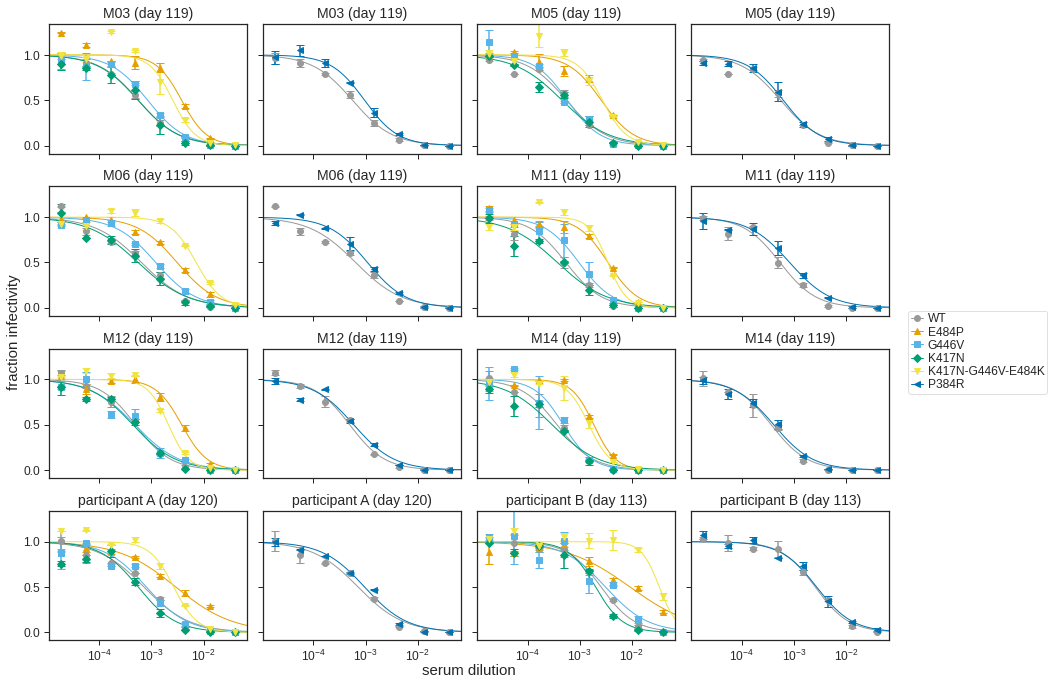

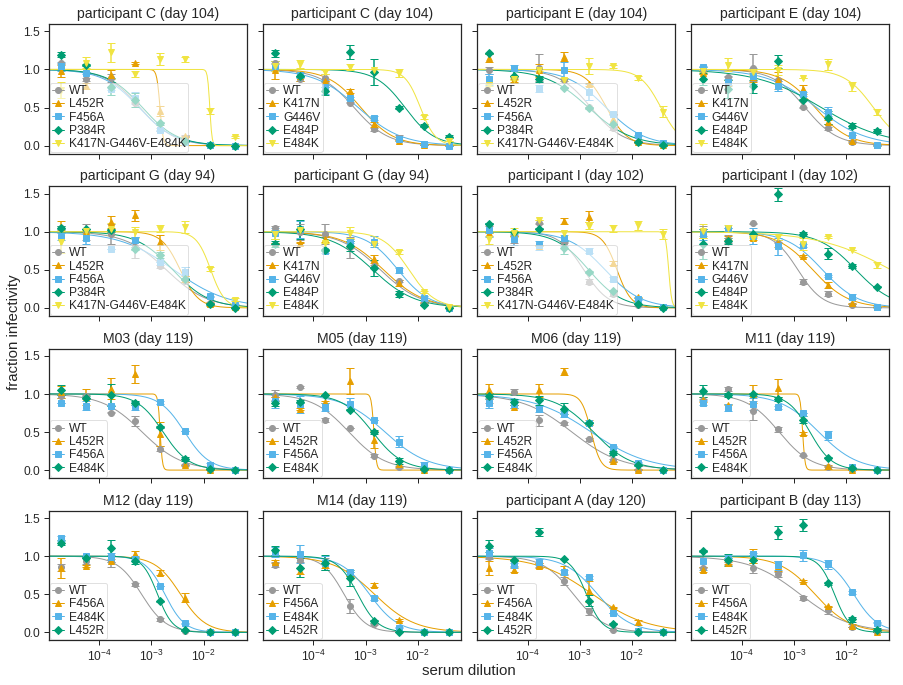

In [10]:
for d in frac_infect['date'].unique():
    fits = neutcurve.CurveFits(frac_infect.query('date==@d'))
    xlab= 'serum dilution'
    name= 'sera'

    fig, axes = fits.plotSera(xlabel=xlab,)

    plotfile = f'./{resultsdir}/{d}_mutant_neuts.pdf'
    print(f"Saving to {plotfile}")
    fig.savefig(plotfile, bbox_inches='tight')

Plot the triple mutant and composite single mutants for one convalescent and one vaccine sample, for main-text figure.

I think M11 and subject E

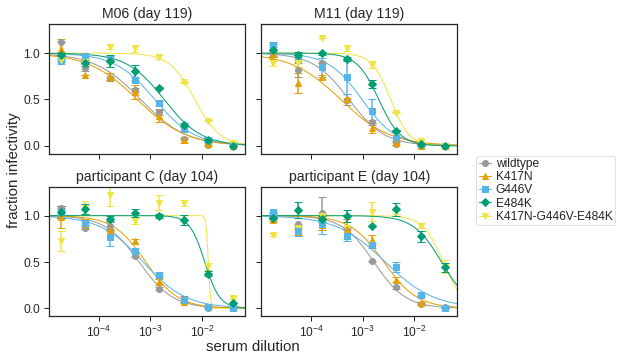

Saving to results/mutant_neuts_results/main_fig_neut.pdf


In [11]:
# key sera of interest
sera_to_plot = ['M06 (day 119)', 'M11 (day 119)',
                'participant C (day 104)', 'participant E (day 104)']
# key viruses of interest
viruses_to_plot = ['WT',
                   'K417N',
                   'G446V',
                   'E484K',
                   'K417N-G446V-E484K'
                   ]

# Now plot by sera **not** including assay date; when multiple measurements for
# an assay date just take the first one.
df = (frac_infect
      .query('(serum in @sera_to_plot) and (virus in @viruses_to_plot)')
      .assign(first_assay_date=lambda x: x.groupby(['serum', 'virus'])['date'].transform('first'))
      .query('date == first_assay_date')
      .replace({'WT':'wildtype'})
      )

df.head()
fits = neutcurve.CurveFits(df,
                           serum_col='serum')
fig, _ = fits.plotSera(xlabel='serum dilution',
                       viruses=["wildtype" if x=="WT" else x for x in viruses_to_plot],
                       ncol=2,
                       heightscale=1,
                       widthscale=1,
                       max_viruses_per_subplot=len(viruses_to_plot),
                       sharex=True,
                       )
display(fig)
plotfile = os.path.join(resultsdir, 'main_fig_neut.pdf')
print(f"Saving to {plotfile}")
fig.savefig(plotfile, bbox_inches='tight')
plt.close(fig)

## Get depletion NT50s and fold-change

In [12]:
haarvi_samples = config["validated_samples"].values()
haarvi_depletions = (pd.read_csv(config['haarvi_depletions'])
                     [['serum','fold_change', 'NT50_post', 'post-depletion_ic50', 'post_ic50_bound']]
                     .drop_duplicates()
                     .rename(columns={'NT50_post':'NT50', 
                                      'post-depletion_ic50':'ic50', 
                                      'post_ic50_bound':'ic50_is_bound'})
                     .assign(log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                             virus='RBD antibodies depleted'
                            )
                     .query('serum in @haarvi_samples')
                    )

haarvi_depletions_wt = (pd.read_csv(config['haarvi_depletions'])
                     [['serum','fold_change', 'NT50_pre', 'pre-depletion_ic50']]
                     .drop_duplicates()
                     .rename(columns={'NT50_pre':'NT50', 
                                      'pre-depletion_ic50':'ic50', 
                                      })
                     .assign(fold_change=1,
                             log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                             virus='wildtype'
                            )
                     .query('serum in @haarvi_samples')
                    )

moderna_depletions = (pd.read_csv(config['moderna_depletions'])
                      [['serum','fold_change', 'NT50_post', 'post-depletion_ic50', 'post_ic50_bound']]
                      .drop_duplicates()
                      .rename(columns={'NT50_post':'NT50', 
                                      'post-depletion_ic50':'ic50', 
                                      'post_ic50_bound':'ic50_is_bound'})
                      .assign(log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                              serum=lambda x: x['serum'].map(config['validated_samples']),
                              virus='RBD antibodies depleted'
                             )
                      .dropna(subset=['serum'])
                     )

moderna_depletions_wt = (pd.read_csv(config['moderna_depletions'])
                      [['serum','fold_change', 'NT50_pre', 'pre-depletion_ic50']]
                      .drop_duplicates()
                      .rename(columns={'NT50_pre':'NT50', 
                                      'pre-depletion_ic50':'ic50', 
                                      })
                      .assign(fold_change=1,
                              log2_fold_change=lambda x: np.log(x['fold_change']) / np.log(2),
                              serum=lambda x: x['serum'].map(config['validated_samples']),
                              virus='wildtype'
                             )
                      .dropna(subset=['serum'])
                     )

depletion_df = (pd.concat(
    [moderna_depletions, haarvi_depletions, moderna_depletions_wt, haarvi_depletions_wt],
    axis=0,
    ignore_index=True)
                .fillna(False)
               )
display(HTML(depletion_df.to_html(index=False)))

serum,fold_change,NT50,ic50,ic50_is_bound,log2_fold_change,virus
M03 (day 119),44.120772,25.000000,0.040000,True,5.463386,RBD antibodies depleted
M05 (day 119),70.659257,25.000000,0.040000,True,6.142807,RBD antibodies depleted
M06 (day 119),13.299399,72.471105,0.013799,False,3.733289,RBD antibodies depleted
M11 (day 119),51.592102,25.000000,0.040000,True,5.689078,RBD antibodies depleted
M12 (day 119),67.771270,25.000000,0.040000,True,6.082602,RBD antibodies depleted
M14 (day 119),52.573884,53.834278,0.018576,False,5.716274,RBD antibodies depleted
participant A (day 120),43.058197,20.000000,0.050000,True,5.428216,RBD antibodies depleted
participant B (day 113),14.243019,20.000000,0.050000,True,3.832183,RBD antibodies depleted
participant C (day 104),69.152358,20.000000,0.050000,True,6.111707,RBD antibodies depleted
participant E (day 104),35.318485,20.000000,0.050000,True,5.142352,RBD antibodies depleted


## Read in escape fractions

In [13]:
escape_fracs_file = os.path.join('..', global_config['escape_fracs'])
escape_fracs = pd.read_csv(escape_fracs_file).query('library == "average"')

escape_metrics = [global_config['site_metric'], global_config['mut_metric']]

display(HTML(escape_fracs.head().to_html(index=False)))

selection,library,condition,site,label_site,wildtype,mutation,protein_chain,protein_site,mut_escape_frac_epistasis_model,mut_escape_frac_single_mut,site_total_escape_frac_epistasis_model,site_total_escape_frac_single_mut,site_avg_escape_frac_epistasis_model,site_avg_escape_frac_single_mut,nlibs
12C_d152_80,average,12C_d152_80,1,331,N,A,E,331,0.002020,0.001326,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,D,E,331,0.005616,0.000537,0.04926,0.0478,0.003079,0.002988,1
12C_d152_80,average,12C_d152_80,1,331,N,E,E,331,0.002535,0.000482,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,F,E,331,0.003032,0.005816,0.04926,0.0478,0.003079,0.002988,2
12C_d152_80,average,12C_d152_80,1,331,N,G,E,331,0.003113,0.001273,0.04926,0.0478,0.003079,0.002988,2


In [14]:
print(config['map_conditions'])

{'M06-day-119_80': 'M06 (day 119)', 'M11-day-119_200': 'M11 (day 119)', 'M05-day-119_500': 'M05 (day 119)', 'M03-day-119_200': 'M03 (day 119)', 'M12-day-119_200': 'M12 (day 119)', 'M14-day-119_500': 'M14 (day 119)', '24C_d104_200': 'participant C (day 104)', '22C_d104_200': 'participant E (day 104)', '23C_d102_80': 'participant I (day 102)', '1C_d113_200': 'participant B (day 113)', '23_d120_500': 'participant A (day 120)', '25_d94_200': 'participant G (day 94)'}


In [15]:
samples = config['map_conditions'].values()
escape_fracs_df = (escape_fracs
                   .replace(config['map_conditions'])
                   .query('selection in @samples')
                   [['selection', 'label_site', 'wildtype', 'mutation', global_config['site_metric'], global_config['mut_metric']]]
                   .rename(columns={'selection':'serum', 
                                    'label_site': 'site', 
                                    global_config['mut_metric']:'mutation escape',
                                    global_config['site_metric']:'site total escape',
                                   }
                          )
                   .assign(virus=lambda x: x['wildtype'] + x['site'].astype(str) + x['mutation'],
                           site_label=lambda x: x['wildtype'] + x['site'].astype(str),
                           site=lambda x: x['site'].astype(str)
                          )
                   .drop(columns=['wildtype', 'mutation', 'site_label', 'site'])
                  )

display(HTML(escape_fracs_df.head().to_html(index=False)))

serum,site total escape,mutation escape,virus
participant B (day 113),0.2028,0.01312,N331A
participant B (day 113),0.2028,0.02020,N331D
participant B (day 113),0.2028,0.01226,N331E
participant B (day 113),0.2028,0.01330,N331F
participant B (day 113),0.2028,0.01373,N331G


## Make plot showing NT50 for each genotype (wildtype or mutant) for each serum.
This is actually an important thing we should probably add to the paper. 
Even though the NT50s decrease by ~10-fold or more for some sera against some mutants, the absolute NT50 remaining might still be quite potent. 
It would be nice to have this clearly shown.

In [16]:
muts_depletions = (pd.concat([depletion_df, fc], axis=0, ignore_index=True)
                   .assign(sample_type=lambda x: x['serum'].map(config['sample_types']))
                   .merge(escape_fracs_df,
                          how='left', 
                          on=['serum', 'virus']
                         )
                   .assign(virus=lambda x: pd.Categorical(x['virus'], categories=config['viruses'].keys(), ordered=True),
                           epitope=lambda x: x['virus'].map(config['viruses']),
                          )
               )

display(HTML(muts_depletions.tail().to_html(index=False)))

serum,fold_change,NT50,ic50,ic50_is_bound,log2_fold_change,virus,ic50_bound,date,wildtype_ic50,sample_type,site total escape,mutation escape,epitope
participant A (day 120),1.771949,743.912663,0.001344,False,0.825337,L452R,interpolated,210312,0.000759,convalescent,1.156,0.1171,naturally-occurring
participant B (day 113),1.928334,392.047104,0.002551,False,0.947355,F456A,interpolated,210312,0.001323,convalescent,3.510,0.4938,not naturally-occurring
participant B (day 113),10.647124,71.004888,0.014084,False,3.412392,E484K,interpolated,210312,0.001323,convalescent,3.019,0.1182,naturally-occurring
participant B (day 113),1.000000,755.997863,0.001323,False,0.000000,wildtype,interpolated,210312,0.001323,convalescent,NaN,NaN,naturally-occurring
participant B (day 113),4.559898,165.792731,0.006032,False,2.189001,L452R,interpolated,210312,0.001323,convalescent,1.505,0.1556,naturally-occurring


In [17]:
muts_depletions['virus'].drop_duplicates()

0     RBD antibodies depleted
12                   wildtype
25                      E484P
26                      G446V
27                      K417N
28          K417N-G446V-E484K
29                      P384R
72                      L452R
73                      F456A
79                      E484K
Name: virus, dtype: category
Categories (10, object): ['wildtype' < 'P384R' < 'K417N' < 'G446V' ... 'E484P' < 'E484K' < 'K417N-G446V-E484K' < 'RBD antibodies depleted']

In [18]:
serum_order = list(config['sample_types'].keys())

Saving to results/mutant_neuts_results//all_neuts_NT50.pdf


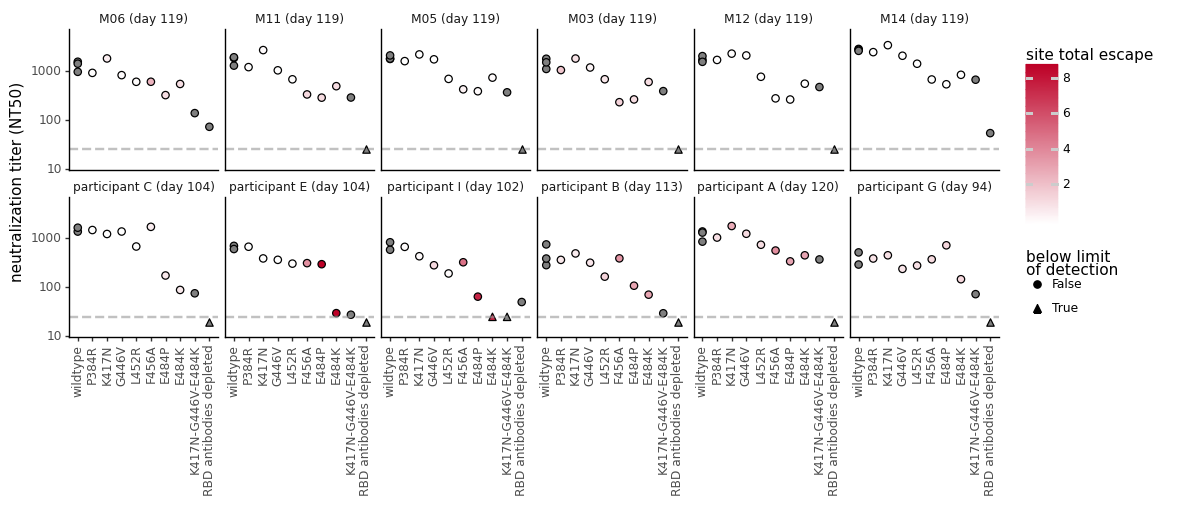

In [19]:
p = (ggplot((muts_depletions.assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=serum_order)))) +
     aes('virus', 'NT50', shape='ic50_is_bound', fill='site total escape') +
     geom_point(size=2.5, alpha=1) +
     scale_x_discrete(name='') +
     scale_y_log10(name='neutralization titer (NT50)', expand=(0.1,0.1)) +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * muts_depletions['virus'].nunique()*muts_depletions['serum'].nunique()/2, 4),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           ) +
         geom_hline(yintercept=25, linetype='dashed', size=1,
                    alpha=0.6, color=CBPALETTE[0]) +
     scale_fill_gradient(low='white', high='#BD0026') +
     scale_shape_manual(values=['o','^'], name='below limit\nof detection')
#      scale_fill_manual(values=['gray', 'white'],name='below limit\nof detection')
#          +scale_color_manual(values=['gray', '#D55E00'],name='E484 mutant')
     )

_ = p.draw()

plotfile = f'{resultsdir}/all_neuts_NT50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Now plot IC50 instead

Saving to results/mutant_neuts_results//all_neuts_IC50.pdf


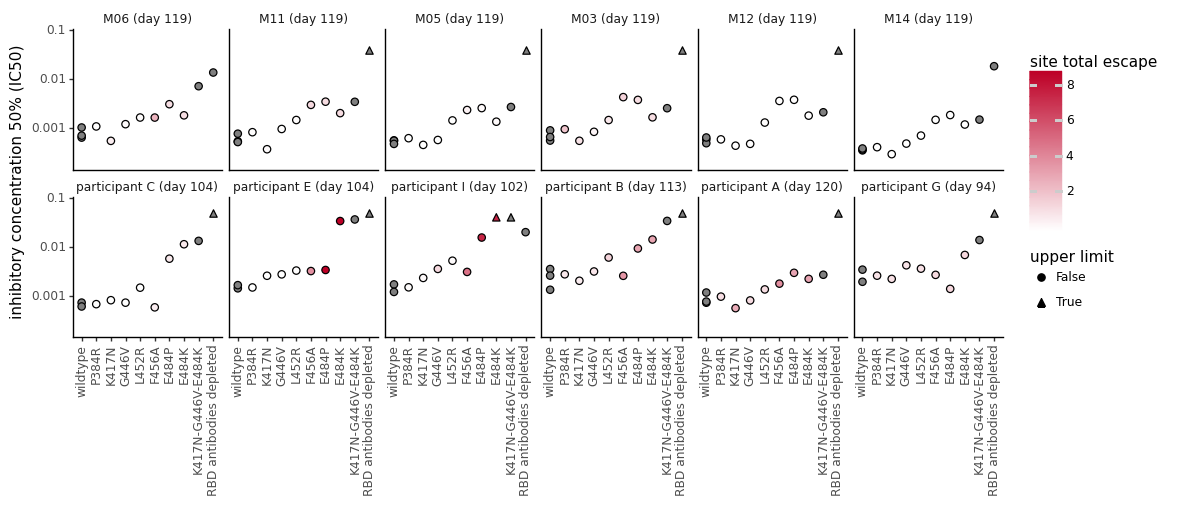

In [20]:
p = (ggplot((muts_depletions.assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=serum_order)))) +
     aes('virus', 'ic50', shape='ic50_is_bound', fill='site total escape') +
     geom_point(size=2.5, alpha=1) +
     scale_x_discrete(name='') +
     scale_y_log10(name='inhibitory concentration 50% (IC50)', expand=(0.1,0.1)) +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * muts_depletions['virus'].nunique()*muts_depletions['serum'].nunique()/2, 4),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           ) +
     scale_fill_gradient(low='white', high='#BD0026') +
     scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/all_neuts_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/mutant_neuts_results//all_neuts_IC50_nocolor.pdf


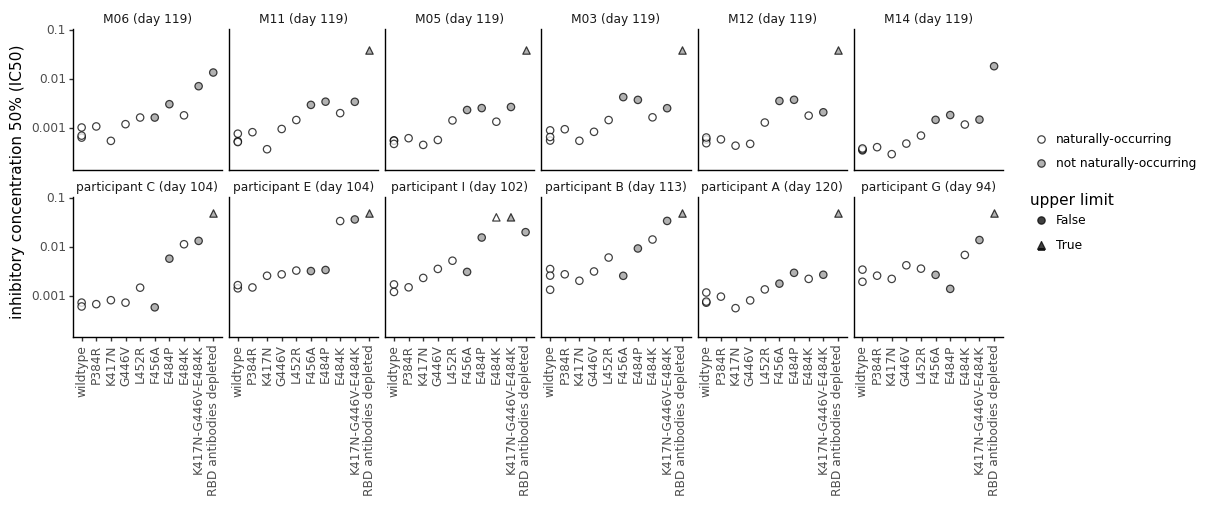

In [21]:
p = (ggplot((muts_depletions.assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=serum_order)))) +
     aes('virus', 'ic50', shape='ic50_is_bound', fill='epitope') +
     geom_point(size=2.5, alpha=0.75) +
     scale_x_discrete(name='') +
     scale_y_log10(name='inhibitory concentration 50% (IC50)', expand=(0.1,0.1)) +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           figure_size=(0.2 * muts_depletions['virus'].nunique()*muts_depletions['serum'].nunique()/2, 4),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           ) +
     scale_fill_manual(values=config['epitope_colors'], name=' ') +
     scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/all_neuts_IC50_nocolor.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

### Plot fold-change IC50 relative to wild type for each mutant.
You could also imagine drawing a dashed line with the fold-change with RBD depletion, which sets an upper limit on what we would expect to see (the max drop in NT50 we could see due to anything RBD-related). 

To do this you would need to:
* Read in foldchange IC50 due to RBD depletion (specify path in config file)
* Merge with mutant `foldchange` dataframe
* Add `geom_hline` with depletion foldchange

Saving to results/mutant_neuts_results//fold_change_IC50.pdf


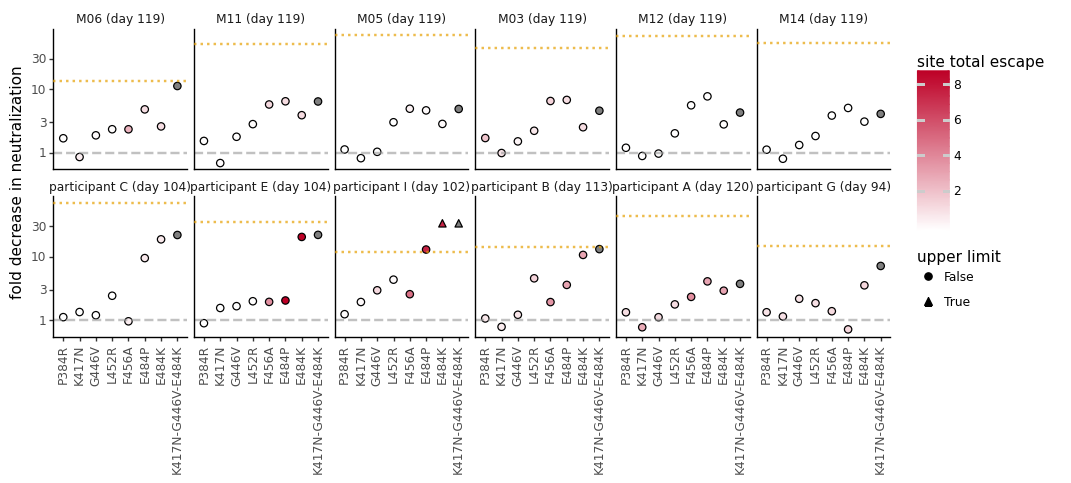

In [22]:
muts_depletions = (muts_depletions
                   .assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=serum_order))
                  )
    
p = (ggplot(muts_depletions
            .query("virus != 'RBD antibodies depleted' & virus != 'wildtype'")
            ) +
     aes('virus', 'fold_change', fill='site total escape', shape='ic50_is_bound',
        ) +
     geom_point(size=2.5, alpha=1) +
     scale_y_log10(name='fold decrease in neutralization') +
     facet_wrap('~serum', ncol=6) +
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           axis_title_x=element_blank(),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
           figure_size=(0.2 * (muts_depletions['virus'].nunique()-1)*muts_depletions['serum'].nunique()/2, 4),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=muts_depletions.query('virus=="RBD antibodies depleted"'),
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[1],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_fill_gradient(low='white', high='#BD0026') +
     scale_shape_manual(values=['o','^'], name='upper limit')
#      scale_color_manual(values=CBPALETTE[1:],
#                         name='upper limit') +
#      scale_fill_manual(values=['gray', 'white'],name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/mutant_neuts_results//fold_change_IC50_nocolor.pdf


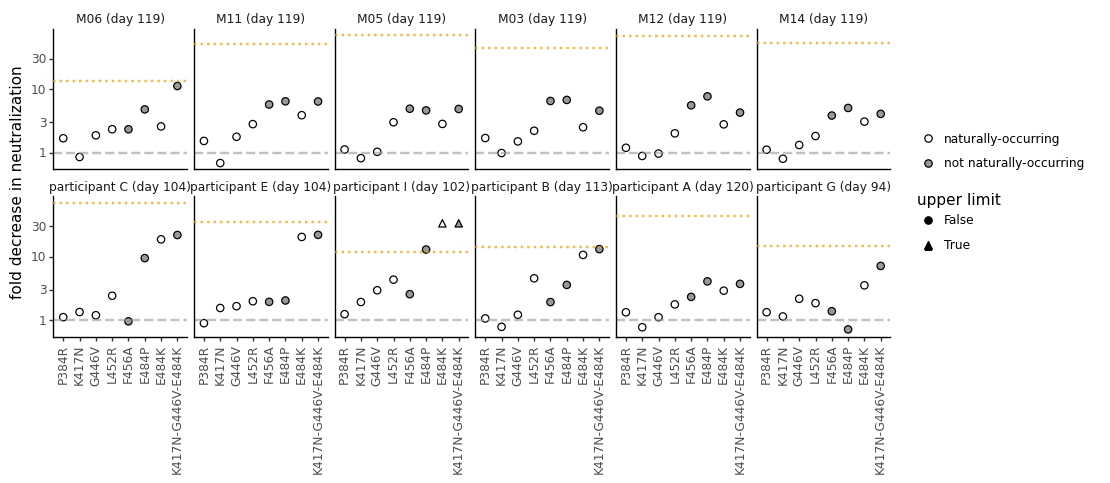

In [23]:
muts_depletions = (muts_depletions
                   .assign(serum=lambda x: pd.Categorical(x['serum'],ordered=True,categories=serum_order))
                  )
    
p = (ggplot(muts_depletions
            .query("virus != 'RBD antibodies depleted' & virus != 'wildtype'")
            ) +
     aes('virus', 'fold_change', shape='ic50_is_bound', fill='epitope'
        ) +
     geom_point(size=2.5, alpha=1, ) + #fill='#999999'
     scale_y_log10(name='fold decrease in neutralization') +
     facet_wrap('~serum', ncol=6, ) + #scales='free_x'
     theme_classic() +
     theme(axis_text_x=element_text(angle=90),
           axis_title_x=element_blank(),
           strip_margin_y=0.35,
           strip_background_x=element_blank(),
#            subplots_adjust={'hspace':1},
           figure_size=(0.2 * (muts_depletions['virus'].nunique()-1)*muts_depletions['serum'].nunique()/2, 4),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(data=muts_depletions.query('virus=="RBD antibodies depleted"'),
                mapping=aes(yintercept='fold_change'),
                color=CBPALETTE[1],
                alpha=0.7,
                size=1,
                linetype='dotted',
               ) +
     scale_fill_manual(values=config['epitope_colors'], name=' ') +
     scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_nocolor.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/mutant_neuts_results//fold_change_IC50_dodged.pdf


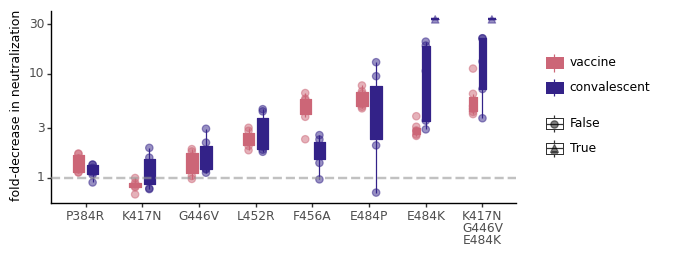

In [24]:
p = (ggplot(muts_depletions
            .query("virus != 'wildtype' & virus != 'RBD antibodies depleted'")
            .assign(sample_type=lambda x: pd.Categorical(x['sample_type'],ordered=True,categories=['vaccine', 'convalescent']))
             .replace({'K417N-G446V-E484K':'K417N\nG446V\nE484K'})
             .assign(virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=list(config['viruses'].keys())+['K417N\nG446V\nE484K']))
            ) +
     aes('virus', 'fold_change', fill='sample_type', color='sample_type', shape='ic50_is_bound',) + 
     geom_boxplot(aes(), #color='sample_type'
                  width=0.4,
                  position=position_dodge(width=0.5),
                  outlier_shape='',
                 ) +
     geom_jitter(position=position_dodge(width=0.5), size=2.5, alpha=0.5) +
     scale_y_log10(name='fold-decrease in neutralization') +
     theme_classic() +
     theme(axis_title_x=element_blank(),
           axis_title_y=element_text(size=9),
           legend_title=element_blank(),
#            legend_title=element_text(size=10),
           figure_size=(0.75 * (muts_depletions['virus'].nunique()-2), 2.5),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     scale_fill_manual(values=['#CC6677', '#332288'])+
     scale_color_manual(values=['#CC6677', '#332288']) +
     scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_dodged.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

In [25]:
median_df=(muts_depletions
 .groupby(['virus', 'sample_type'], as_index=False)
 .aggregate(ic50=pd.NamedAgg(column='ic50', aggfunc='median'),
            fold_change=pd.NamedAgg(column='fold_change', aggfunc='median'),
           )
           .reset_index()
           .assign(sample_type=lambda x: pd.Categorical(x['sample_type'],
                                                        ordered=True,
                                                        categories=['vaccine', 'convalescent'])
                  )
           .replace({'K417N-G446V-E484K':'K417N\nG446V\nE484K',
                     'RBD antibodies depleted':'all RBD\nantibodies\ndepleted'
                    }
                   )
           .assign(virus=lambda x: pd.Categorical(x['virus'],
                                                  ordered=True,
                                                  categories=list(config['viruses'].keys())+['K417N\nG446V\nE484K','all RBD\nantibodies\ndepleted']))
)

Saving to results/mutant_neuts_results//fold_change_IC50_dodged_wt.pdf


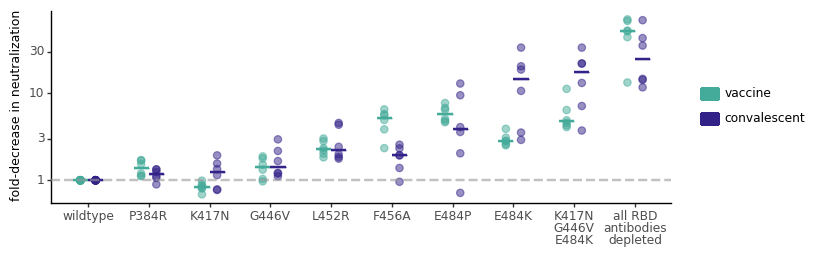

In [26]:
p = (ggplot(muts_depletions
#             .query("virus != 'wildtype' & virus != 'RBD antibodies depleted'")
            .assign(sample_type=lambda x: pd.Categorical(x['sample_type'],ordered=True,categories=['vaccine', 'convalescent']))
             .replace({'K417N-G446V-E484K':'K417N\nG446V\nE484K',
                       'RBD antibodies depleted':'all RBD\nantibodies\ndepleted'
                      }
                     )
             .assign(virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=list(config['viruses'].keys())+['K417N\nG446V\nE484K','all RBD\nantibodies\ndepleted']))
            ) +
     aes('virus', 'fold_change', fill='sample_type', color='sample_type', ) + #shape='ic50_is_bound'
     geom_crossbar(data=(median_df),
                   mapping=aes(x='virus', ymin='fold_change', ymax='fold_change'),
                   position=position_dodge(width=0.5),
                  ) +
     geom_jitter(position=position_dodge(width=0.5), size=2.5, alpha=0.5) +
     scale_y_log10(name='fold-decrease in neutralization') +
     theme_classic() +
     theme(axis_title_x=element_blank(),
           axis_title_y=element_text(size=9),
           legend_title=element_blank(),
#            legend_title=element_text(size=10),
           figure_size=(0.8 * (muts_depletions['virus'].nunique()), 2.5),
           ) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     scale_fill_manual(values=['#44AA99', '#332288'])+
     scale_color_manual(values=['#44AA99', '#332288']) #+
#      scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_dodged_wt.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/mutant_neuts_results//IC50_dodged.pdf


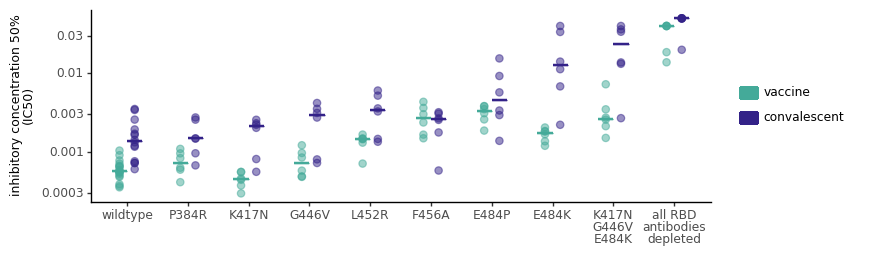

In [27]:
p = (ggplot(muts_depletions
#             .query("virus != 'wildtype' & virus != 'RBD antibodies depleted'")
            .assign(sample_type=lambda x: pd.Categorical(x['sample_type'],ordered=True,categories=['vaccine', 'convalescent']))
             .replace({'K417N-G446V-E484K':'K417N\nG446V\nE484K',
                       'RBD antibodies depleted':'all RBD\nantibodies\ndepleted'
                      }
                     )
             .assign(virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=list(config['viruses'].keys())+['K417N\nG446V\nE484K','all RBD\nantibodies\ndepleted']))
            ) +
     aes('virus', 'ic50', fill='sample_type', color='sample_type', ) + # shape='ic50_is_bound'
     geom_jitter(aes(fill='sample_type', color='sample_type'), position=position_dodge(width=0.5), size=2.5, alpha=0.5) +
     geom_crossbar(data=(median_df),
                   mapping=aes(x='virus', ymin='ic50', ymax='ic50'),
                   position=position_dodge(width=0.5),
                  ) +
     scale_y_log10(name='inhibitory concentration 50%\n(IC50)') +
#      geom_hline(yintercept=0.04, linetype='dotted', size=1,
#                 alpha=0.6, color='#CCBB44') +
     theme_classic() +
     theme(axis_title_x=element_blank(),
           axis_title_y=element_text(size=9),
           legend_title=element_blank(),
           figure_size=(0.8 * (muts_depletions['virus'].nunique()), 2.5),
           ) +
     scale_fill_manual(values=['#44AA99', '#332288'])+
     scale_color_manual(values=['#44AA99', '#332288']) #+
#      scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/IC50_dodged.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Show the triple and its composite mutations only

In [28]:
print(muts_depletions.query('virus=="RBD antibodies depleted"')['fold_change'].max())

70.65925651203779


Saving to results/mutant_neuts_results//fold_change_IC50_triple.pdf


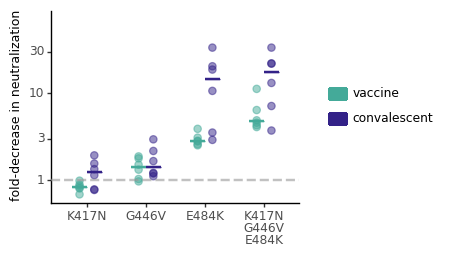

In [29]:
triples = ['K417N', 'G446V', 'E484K', 'K417N-G446V-E484K', 'K417N\nG446V\nE484K']

p = (ggplot(muts_depletions
            .query("virus in @triples")
            .assign(sample_type=lambda x: pd.Categorical(x['sample_type'],ordered=True,categories=['vaccine', 'convalescent']))
             .replace({'K417N-G446V-E484K':'K417N\nG446V\nE484K',
                       'RBD antibodies depleted':'all RBD\nantibodies\ndepleted'
                      }
                     )
             .assign(virus=lambda x: pd.Categorical(x['virus'],ordered=True,categories=list(config['viruses'].keys())+['K417N\nG446V\nE484K','all RBD\nantibodies\ndepleted']))
            ) +
     aes('virus', 'fold_change', fill='sample_type', color='sample_type', ) + #shape='ic50_is_bound'
     geom_crossbar(data=(median_df.query("virus in @triples")),
                   mapping=aes(x='virus', ymin='fold_change', ymax='fold_change'),
                   position=position_dodge(width=0.5),
                  ) +
     geom_jitter(position=position_dodge(width=0.5), size=2.5, alpha=0.5) +
     scale_y_log10(name='fold-decrease in neutralization') +
     theme_classic() +
     theme(axis_title_x=element_blank(),
           axis_title_y=element_text(size=9),
           legend_title=element_blank(),
#            legend_title=element_text(size=10),
           figure_size=(0.8 * 4, 2.5),
           ) +
     # add invisible line to make y-axis max the same as for panel 5B
     geom_hline(yintercept=muts_depletions.query('virus=="RBD antibodies depleted"')['fold_change'].max(), 
                linetype='dashed', size=0,
                alpha=0.6, color=CBPALETTE[0]) +
     geom_hline(yintercept=1, linetype='dashed', size=1,
                alpha=0.6, color=CBPALETTE[0]) +
     scale_fill_manual(values=['#44AA99', '#332288'])+
     scale_color_manual(values=['#44AA99', '#332288']) #+
#      scale_shape_manual(values=['o','^'], name='upper limit')
     )

_ = p.draw()

plotfile = f'{resultsdir}/fold_change_IC50_triple.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Plot viral entry titers as RLU/uL

Saving to results/mutant_neuts_results//entry_titers_techreps.pdf


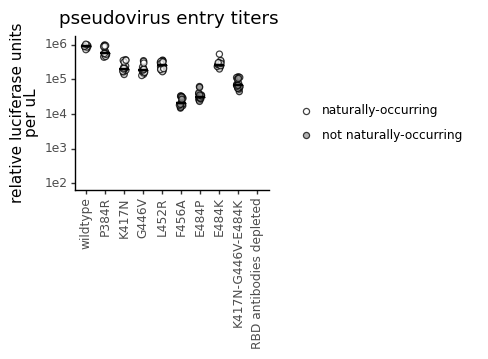

In [30]:
entry_titers = (pd.read_csv(config['titer_input_file'])
                .assign(virus=lambda x: pd.Categorical(x['virus'], 
                                                       categories=config['viruses'].keys(), 
                                                       ordered=True),
                        epitope=lambda x: x['virus'].map(config['viruses']),
                       )
                .rename(columns={'RLU per uL':'RLU_per_uL'})
               )

p = (ggplot(entry_titers, 
            aes(x='virus', y='RLU_per_uL', fill='epitope')
           ) +
     geom_point(size=2,alpha=0.75, position=position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.2, random_state=123)) +
     geom_crossbar(data=(entry_titers
                         .groupby(['virus'], as_index=False)
                         .aggregate(RLU_per_uL=pd.NamedAgg(column='RLU_per_uL', aggfunc='median'))),
                   mapping=aes(x='virus', y='RLU_per_uL', ymin='RLU_per_uL', ymax='RLU_per_uL'),
                   inherit_aes=False,
           )+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(2.5,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[100,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_fill_manual(values=config['epitope_colors'], name=' ')
    )

_ = p.draw()

plotfile = f'{resultsdir}/entry_titers_techreps.pdf'
print(f"Saving to {plotfile}")
p.save(plotfile, verbose=False)

Saving to results/mutant_neuts_results//entry_titers_mean.pdf
Saving to results/mutant_neuts_results//entry_titers_median.pdf


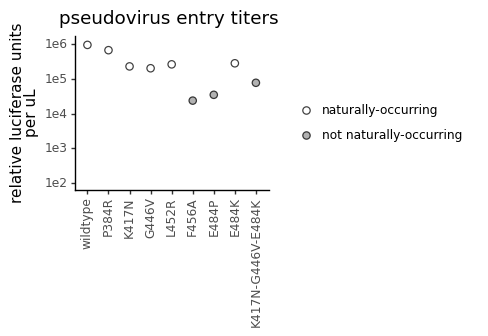

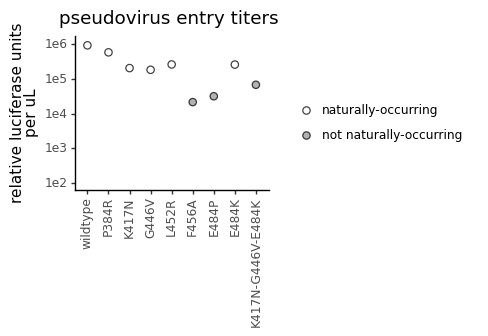

In [31]:
for metric in ['mean', 'median']:
    p = (ggplot((entry_titers
                 .groupby(['virus'], as_index=False)
                 .aggregate(RLU_per_uL=pd.NamedAgg(column='RLU_per_uL', aggfunc=metric))
                 .merge(entry_titers[['virus','epitope']].drop_duplicates())
                ), 
                aes(x='virus', y='RLU_per_uL', fill='epitope')
               ) +
         geom_point(size=2.5, alpha=0.75)+
         theme_classic() +
         theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
               figure_size=(2.5,2),
               axis_title_x=element_blank(),
              ) +
         scale_y_log10(limits=[100,1.1e6]) +
         ylab('relative luciferase units\nper uL')+
         labs(title='pseudovirus entry titers') +
         scale_fill_manual(values=config['epitope_colors'], name=' ')
        )

    _ = p.draw()
    
    plotfile = f'{resultsdir}/entry_titers_{metric}.pdf'
    print(f"Saving to {plotfile}")
    p.save(plotfile, verbose=False)

In [33]:
!jupyter nbconvert mutant_neuts.ipynb --to markdown

[NbConvertApp] Converting notebook mutant_neuts.ipynb to markdown
[NbConvertApp] Support files will be in mutant_neuts_files/
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Making directory mutant_neuts_files
[NbConvertApp] Writing 49774 bytes to mutant_neuts.md
